## Imports

In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 


import librosa
from librosa import display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Load Data

In [3]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
sr = 22050
Y_LIMIT = 660000

In [4]:
class DataLoader():
    def __init__(self):
        self.X = None
        self.X_mfcc = None
        self.X_mfcc_pca = None
        self.X_chroma = None
        self.X_chroma_pca = None
        self.pca_mfcc = None
        self.pca_chroma = None
        self.Y = None
        
    def save_raw(self, genres=all_genres, songs=num_songs):
        assert(self.X is None and self.Y is None)
        X, Y = None, None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
                y = y[:Y_LIMIT]
                if X is None:
                    X = y.reshape(1, y.shape[0])
                    Y = np.array([[g_idx]])
                else:
                    X = np.vstack([X, y])
                    Y = np.vstack([Y, np.array([[g_idx]])])
        Y = Y.ravel()
        self.X = X
        self.Y = Y
        np.savetxt('data/X.csv', X)
        np.savetxt('data/Y.csv', Y)
        
    def save_mfcc(self):
        assert(self.X_mfcc is None)
        X_mfcc = None
        for i in range(self.X.shape[0]):
            mfcc = librosa.feature.mfcc(y=self.X[i], sr=sr, hop_length=512, n_mfcc=13).flatten()
            if X_mfcc is None:
                X_mfcc = mfcc.reshape(1, mfcc.shape[0])
            else:
                X_mfcc = np.vstack([X_mfcc, mfcc])
        self.X_mfcc = X_mfcc
        np.savetxt('data/X_mfcc.csv', X_mfcc)
        
    def save_mfcc_pca(self, pca_dims=100):
        assert(self.X_mfcc_pca is None and self.pca_mfcc is None)
        pca_mfcc = PCA(n_components=pca_dims, random_state=1)
        X_mfcc_pca = pca_mfcc.fit_transform(self.X_mfcc)
        self.pca_mfcc = pca_mfcc
        self.X_mfcc_pca = X_mfcc_pca
        np.savetxt(f'data/X_mfcc_pca{pca_dims}.csv', X_mfcc_pca)
        dump(pca_mfcc, f'data/pca_mfcc{pca_dims}.PCA') 
    
    def save_chroma(self):
        assert(self.X_chroma is None)
        X_chroma = None
        for i in range(self.X.shape[0]):
            chroma = librosa.feature.chroma_cqt(y=self.X[i], sr=sr, hop_length=512).flatten()
            if X_chroma is None:
                X_chroma = chroma.reshape(1, chroma.shape[0])
            else:
                X_chroma = np.vstack([X_chroma, chroma])
        self.X_chroma = X_chroma
        np.savetxt('data/X_chroma.csv', X_chroma)
    
    def save_chroma_pca(self, pca_dims=100):
        assert(self.X_chroma_pca is None and self.pca_chroma is None)
        pca_chroma = PCA(n_components=pca_dims)
        X_chroma_pca = pca_chroma.fit_transform(self.X_chroma, random_state=1)
        self.pca_chroma = pca_chroma
        self.X_chroma_pca = X_chroma_pca
        np.savetxt(f'data/X_chroma_pca{pca_dims}.csv', X_chroma_pca)
        dump(pca_chroma, f'data/pca_chroma{pca_dims}.PCA') 
    
    def load_raw(self):
        self.X_raw = np.loadtxt('data/X.csv')
        
    def load_mfcc(self):
        self.X_mfcc = np.loadtxt('data/X_mfcc.csv')
        
    def load_mfcc_pca(self, pca_dims=100):
        self.X_mfcc_pca = np.loadtxt(f'data/X_mfcc_pca{pca_dims}.csv')
        self.pca_mfcc = load(f'data/pca_mfcc{pca_dims}.PCA')
        
    def load_chroma(self):
        self.X_chroma = np.loadtxt('data/X_chroma.csv')
    
    def load_chroma_pca(self, pca_dims=100):
        self.X_chroma_pca = np.loadtxt(f'data/X_chroma_pca{pca_dims}.csv')
        self.pca_chroma = load(f'data/pca_chroma{pca_dims}.PCA') 
    
    def load_Y(self):
        self.Y = np.loadtxt('data/Y.csv')

In [5]:
# # Only need to run this ONCE!
# # Saves features and pca objects to data/...
# dl = DataLoader()
# dl.save_raw(genres=all_genres, songs=100)
# dl.save_mfcc()
# dl.save_mfcc_pca()
# dl.save_chroma()
# dl.save_chroma_pca()

In [6]:
# Load from CSVs instead of saving
dl = DataLoader()
dl.load_mfcc()
dl.load_mfcc_pca()
dl.load_chroma()
dl.load_chroma_pca()
dl.load_Y()
print(dl.X_mfcc.shape, dl.X_mfcc_pca.shape, dl.X_chroma.shape, dl.X_chroma_pca.shape, dl.Y.shape)

(1000, 16770) (1000, 100) (1000, 15480) (1000, 100) (1000,)


## Preprocessing

In [44]:
# # Only need to run this ONCE!
# Generates train and test indexes among the 1000 datapoints
# x = np.array([i for i in range(1000)])
# np.random.seed(1)
# train_idxs = np.random.choice(x, size=750, replace=False)
# train_idxs.sort()
# test_idxs = []
# for i in range(1000):
#     if i not in train_idxs:
#         test_idxs.append(i)
# test_idxs = np.array(test_idxs)
# np.savetxt('data/train_idxs.csv', train_idxs)
# np.savetxt('data/test_idxs.csv', test_idxs)

In [56]:
# Load the train/test indexes instead of shuffling
train_idxs = np.loadtxt('data/train_idxs.csv').astype(int)
test_idxs = np.loadtxt('data/test_idxs.csv').astype(int)
print(train_idxs[-1], test_idxs[-1])

999 993


In [110]:
scaler = StandardScaler()
MX = scaler.fit_transform(dl.X_mfcc)
MX_train, MX_test = np.take(MX, train_idxs, 0), np.take(MX, test_idxs, 0)
print(MX_train.shape, MX_test.shape)

(750, 16770) (250, 16770)


In [93]:
scaler = StandardScaler()
X = np.hstack([dl.X_mfcc, dl.X_chroma])
X = scaler.fit_transform(X)
X_train, X_test = np.take(X, train_idxs, 0), np.take(X, test_idxs, 0)
print(X_train.shape, X_test.shape)

(750, 32250) (250, 32250)


In [94]:
scaler = StandardScaler()
PX = np.hstack([dl.X_mfcc_pca, dl.X_chroma_pca])
PX = scaler.fit_transform(PX)
PX_train, PX_test = np.take(PX, train_idxs, 0), np.take(PX, test_idxs, 0)
print(PX_train.shape, PX_test.shape)

(750, 200) (250, 200)


In [95]:
Y = dl.Y
Y_train, Y_test = np.take(Y, train_idxs, 0), np.take(Y, test_idxs, 0)
print(Y_train.shape, Y_test.shape)

(750,) (250,)


## Models

In [96]:
def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title}'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [97]:
def plot_labels_3d(data, labels, title):
    pca = PCA(n_components=3, random_state=1)
    pca.fit(X) # ALWAYS PCA BASED ON TEST/TRAIN MFCC/CHROMA CONCATENATED
    projected = pca.transform(data)
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(title, fontsize=20) 
    ax = fig.add_subplot(111, projection='3d')
    for l, c in zip(range(0, 10),
                    ('blue', 'red', 'green', 'orange', 'yellow', 'black', 'purple', 'cyan', 'brown', 'pink')):
        ax.scatter(projected[labels == l, 0],
                    projected[labels == l, 1],
                    projected[labels == l, 2],
                    color=c,
                    label='%s' % all_genres[l],
                    alpha=.5,
                    marker='o',
                    s=60
                    )
    ax.set_xlabel('PCA dimension 1')
    ax.set_ylabel('PCA dimension 2')
    ax.set_zlabel('PCA dimension 3')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    

## True labels plot

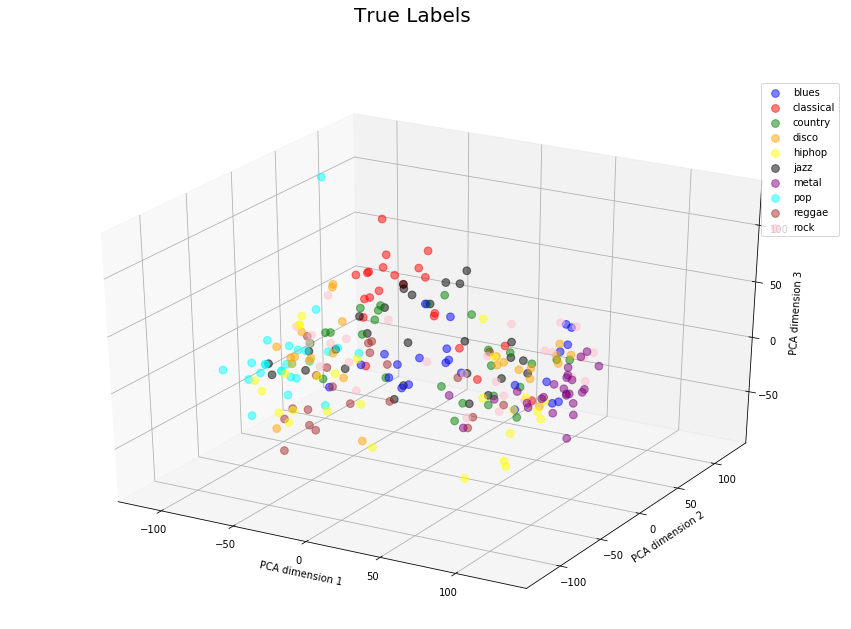

In [98]:
plot_labels_3d(X_test, Y_test, 'True Labels')

## PCA Baselines

Best score for training data: 0.3105790362975831 

Best C: 0.1 

Best Kernel: linear 

Best gamma: auto_deprecated 

              precision    recall  f1-score   support

         0.0       0.29      0.39      0.33        23
         1.0       0.67      0.61      0.64        23
         2.0       0.41      0.46      0.44        26
         3.0       0.22      0.24      0.23        25
         4.0       0.23      0.26      0.25        27
         5.0       0.42      0.50      0.46        28
         6.0       0.71      0.65      0.68        26
         7.0       0.47      0.32      0.38        25
         8.0       0.28      0.25      0.26        20
         9.0       0.15      0.11      0.13        27

    accuracy                           0.38       250
   macro avg       0.39      0.38      0.38       250
weighted avg       0.39      0.38      0.38       250



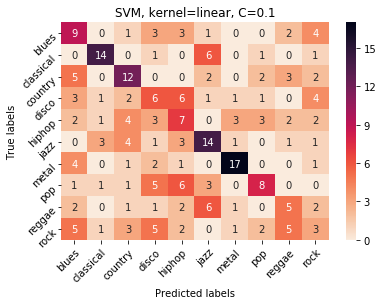

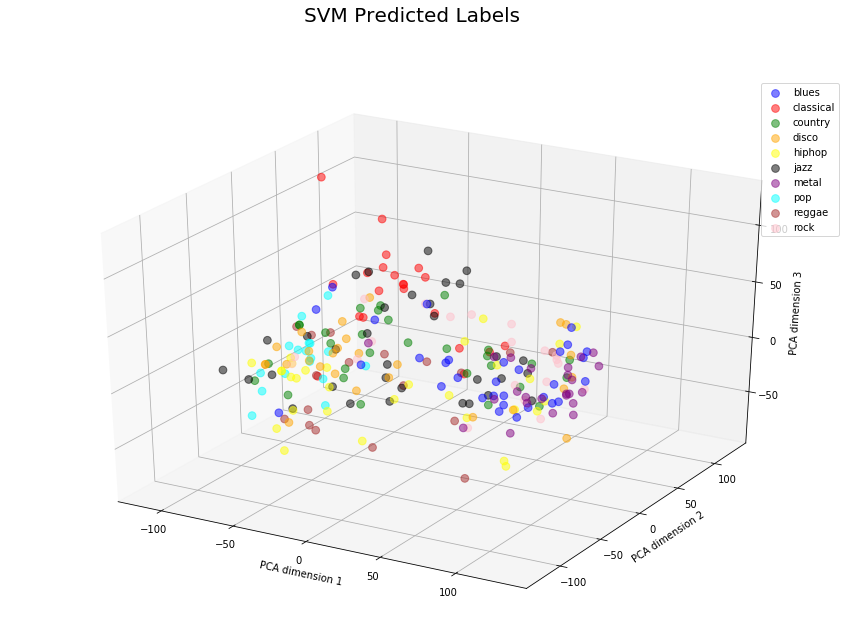

In [99]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [.01, .1, 1]},
                    {'kernel': ['linear'], 'C': [.1, 1]}]
svm_model = GridSearchCV(SVC(), params_grid, iid = False, cv=3)
svm_model.fit(PX_train, Y_train)
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best gamma:',svm_model.best_estimator_.gamma,"\n")
svm_predictions = svm_model.best_estimator_.predict(PX_test)
print(classification_report(Y_test,svm_predictions))
plot_confusion_matrix(Y_test, svm_predictions, f'SVM, kernel={svm_model.best_estimator_.kernel}, C={svm_model.best_estimator_.C}')
plot_labels_3d(X_test, svm_predictions, 'SVM Predicted Labels')

Best score for training data: 0.3185816456529997 

Best C: 0.01 

              precision    recall  f1-score   support

         0.0       0.38      0.57      0.46        23
         1.0       0.69      0.78      0.73        23
         2.0       0.65      0.42      0.51        26
         3.0       0.35      0.28      0.31        25
         4.0       0.25      0.15      0.19        27
         5.0       0.47      0.50      0.48        28
         6.0       0.59      0.88      0.71        26
         7.0       0.48      0.52      0.50        25
         8.0       0.32      0.45      0.38        20
         9.0       0.38      0.19      0.25        27

    accuracy                           0.47       250
   macro avg       0.46      0.47      0.45       250
weighted avg       0.46      0.47      0.45       250



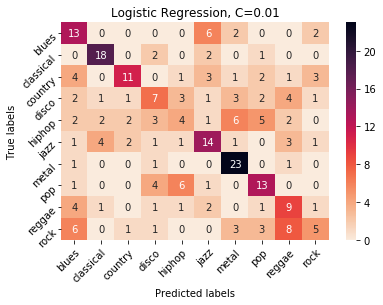

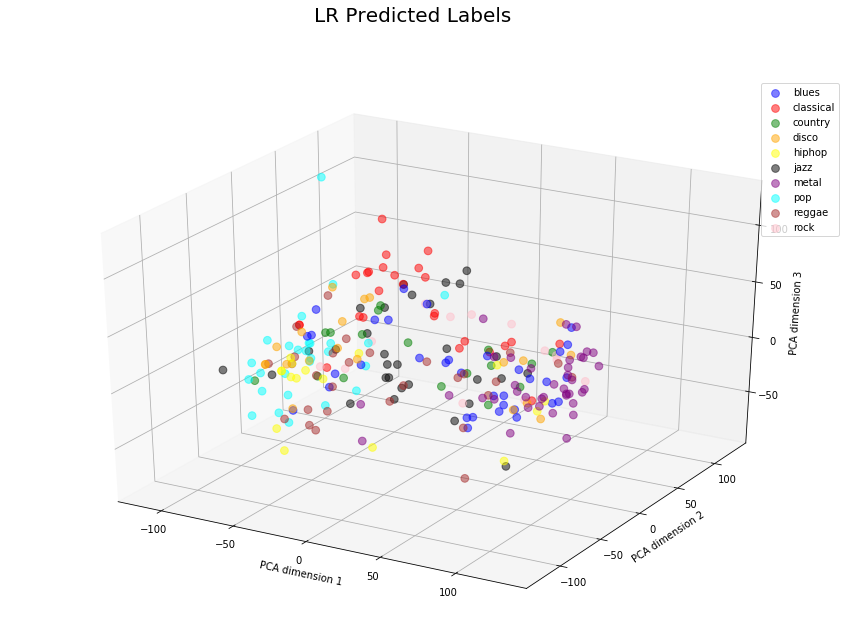

In [100]:
params_grid = [{'C': [.01, .1, 1]}]
lr = GridSearchCV(LogisticRegression(solver='saga', multi_class='multinomial', max_iter=200),
                        params_grid, iid = False, cv=3)
lr.fit(PX_train, Y_train)
print('Best score for training data:', lr.best_score_,"\n") 
print('Best C:',lr.best_estimator_.C,"\n") 
lr_predictions = lr.best_estimator_.predict(PX_test)
print(classification_report(Y_test,lr_predictions))
plot_confusion_matrix(Y_test, lr_predictions, f'Logistic Regression, C={lr.best_estimator_.C}')
plot_labels_3d(X_test, lr_predictions, 'LR Predicted Labels')

Best score for training data: 0.3733094230616338 

Best n_estimators: 80 

Best max_features: sqrt 

              precision    recall  f1-score   support

         0.0       0.29      0.22      0.25        23
         1.0       0.58      0.91      0.71        23
         2.0       0.36      0.38      0.37        26
         3.0       0.28      0.28      0.28        25
         4.0       0.50      0.33      0.40        27
         5.0       0.67      0.36      0.47        28
         6.0       0.57      0.81      0.67        26
         7.0       0.61      0.76      0.68        25
         8.0       0.47      0.70      0.56        20
         9.0       0.31      0.15      0.20        27

    accuracy                           0.48       250
   macro avg       0.46      0.49      0.46       250
weighted avg       0.47      0.48      0.45       250



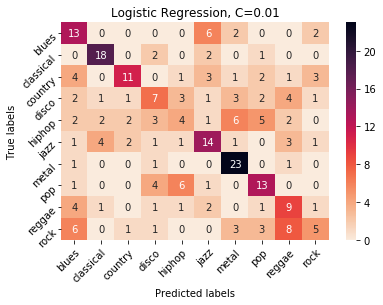

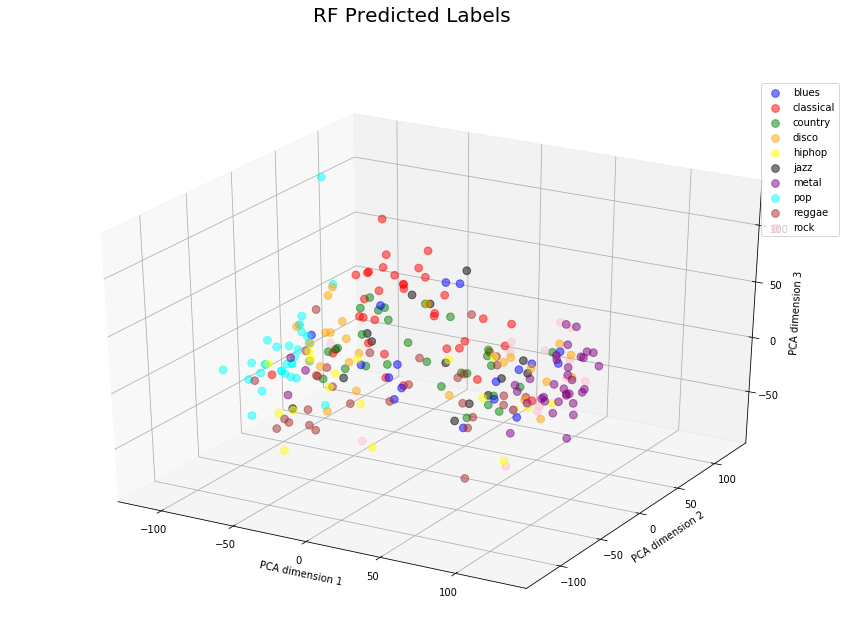

In [101]:
params_grid = [{'n_estimators': [10, 20, 40, 80], 'max_features': ['sqrt', 'log2']}]
rf = GridSearchCV(RandomForestClassifier(), params_grid, iid = False, cv=3)
rf.fit(PX_train, Y_train)
print('Best score for training data:', rf.best_score_,"\n") 
print('Best n_estimators:',rf.best_estimator_.n_estimators,"\n")
print('Best max_features:',rf.best_estimator_.max_features,"\n") 
rf_predictions = rf.best_estimator_.predict(PX_test)
print(classification_report(Y_test, rf_predictions))
plot_confusion_matrix(Y_test, lr_predictions, f'Logistic Regression, C={lr.best_estimator_.C}')
plot_labels_3d(X_test, rf_predictions, 'RF Predicted Labels')

## MFCC+Chroma, Non-PCA Baselines

              precision    recall  f1-score   support

         0.0       0.23      0.30      0.26        23
         1.0       0.60      0.65      0.63        23
         2.0       0.50      0.12      0.19        26
         3.0       0.17      0.04      0.06        25
         4.0       0.00      0.00      0.00        27
         5.0       1.00      0.21      0.35        28
         6.0       0.68      0.88      0.77        26
         7.0       0.43      0.72      0.54        25
         8.0       0.21      0.95      0.35        20
         9.0       0.42      0.19      0.26        27

    accuracy                           0.39       250
   macro avg       0.42      0.41      0.34       250
weighted avg       0.43      0.39      0.34       250



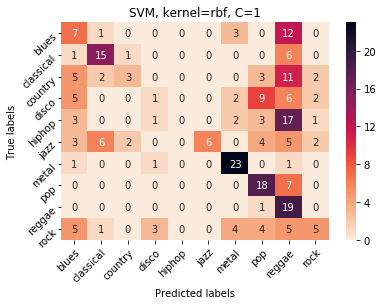

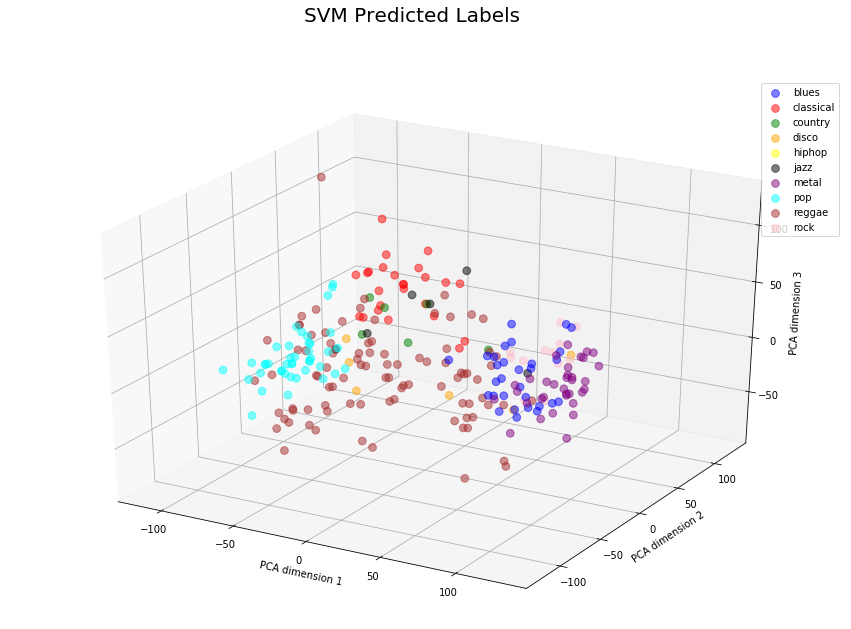

In [102]:
svm_model = SVC(kernel='rbf', gamma=1e-4, C=1)
svm_model.fit(X_train, Y_train)
svm_predictions = svm_model.predict(X_test)
print(classification_report(Y_test,svm_predictions))
plot_confusion_matrix(Y_test, svm_predictions, f'SVM, kernel=rbf, C=1')
plot_labels_3d(X_test, svm_predictions, 'SVM Predicted Labels')

              precision    recall  f1-score   support

         0.0       0.34      0.57      0.43        23
         1.0       0.66      0.91      0.76        23
         2.0       0.50      0.31      0.38        26
         3.0       0.39      0.28      0.33        25
         4.0       0.41      0.26      0.32        27
         5.0       0.47      0.32      0.38        28
         6.0       0.54      0.96      0.69        26
         7.0       0.51      0.84      0.64        25
         8.0       0.44      0.40      0.42        20
         9.0       0.60      0.11      0.19        27

    accuracy                           0.49       250
   macro avg       0.49      0.50      0.45       250
weighted avg       0.49      0.49      0.45       250



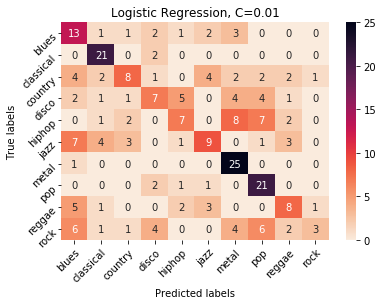

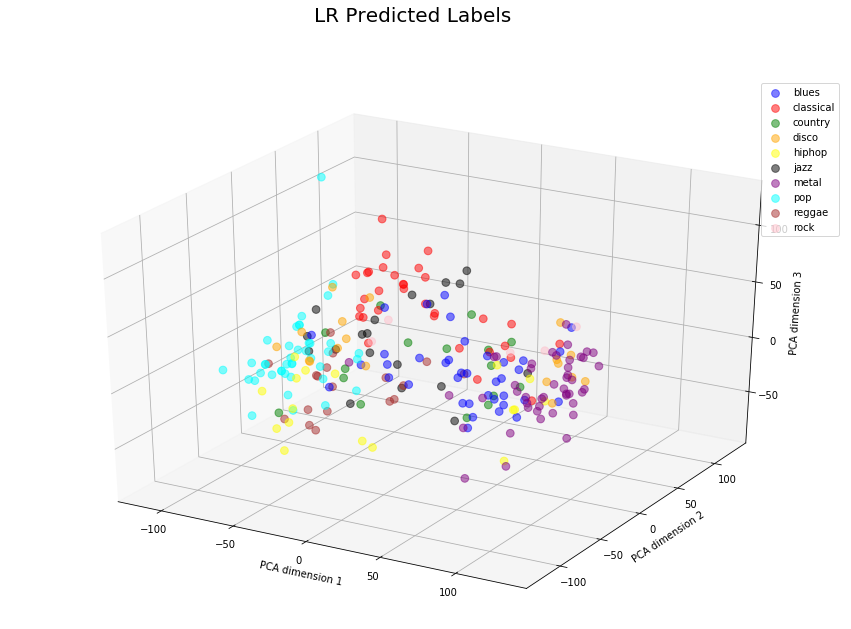

In [106]:
lr = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, C=.01)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)
print(classification_report(Y_test,lr_predictions))
plot_confusion_matrix(Y_test, lr_predictions, f'Logistic Regression, C={.01}')
plot_labels_3d(X_test, lr_predictions, 'LR Predicted Labels')

              precision    recall  f1-score   support

         0.0       0.32      0.43      0.37        23
         1.0       0.70      0.83      0.76        23
         2.0       0.27      0.27      0.27        26
         3.0       0.44      0.28      0.34        25
         4.0       0.40      0.22      0.29        27
         5.0       0.54      0.54      0.54        28
         6.0       0.55      0.85      0.67        26
         7.0       0.44      0.72      0.55        25
         8.0       0.40      0.30      0.34        20
         9.0       0.27      0.11      0.16        27

    accuracy                           0.45       250
   macro avg       0.43      0.45      0.43       250
weighted avg       0.43      0.45      0.43       250



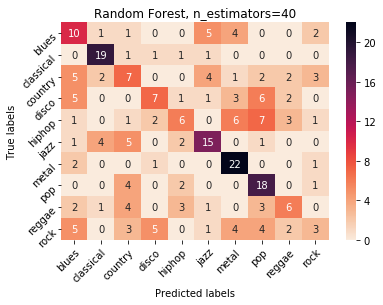

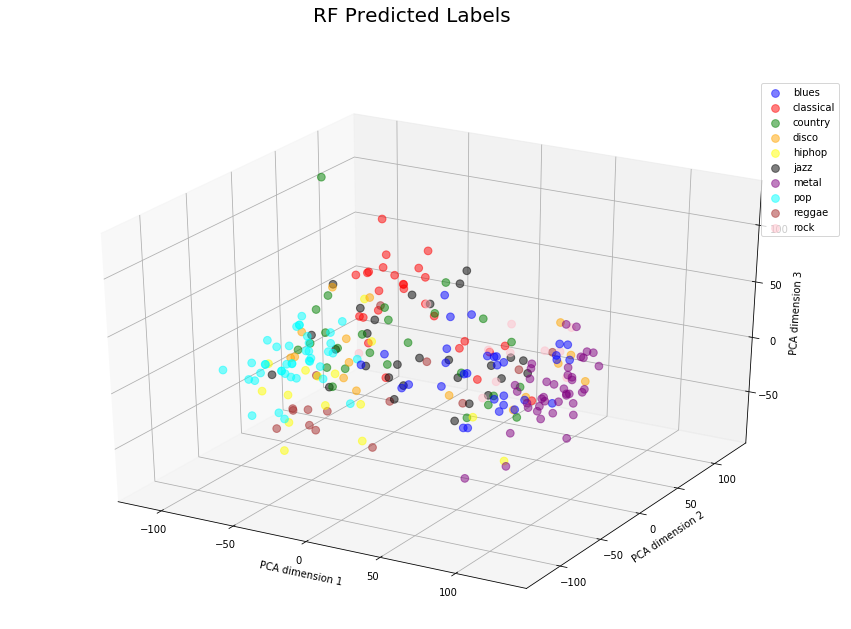

In [108]:
rf = RandomForestClassifier(n_estimators=40, max_features='sqrt')
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)
print(classification_report(Y_test,rf_predictions))
plot_confusion_matrix(Y_test, rf_predictions, f'Random Forest, n_estimators={40}')
plot_labels_3d(X_test, rf_predictions, 'RF Predicted Labels')

## MFCC-Only, No PCA Baselines

              precision    recall  f1-score   support

         0.0       0.52      0.70      0.59        23
         1.0       0.74      0.74      0.74        23
         2.0       0.38      0.31      0.34        26
         3.0       0.35      0.28      0.31        25
         4.0       0.79      0.41      0.54        27
         5.0       0.58      0.64      0.61        28
         6.0       0.79      0.88      0.84        26
         7.0       0.51      0.76      0.61        25
         8.0       0.45      0.65      0.53        20
         9.0       0.40      0.22      0.29        27

    accuracy                           0.55       250
   macro avg       0.55      0.56      0.54       250
weighted avg       0.55      0.55      0.54       250



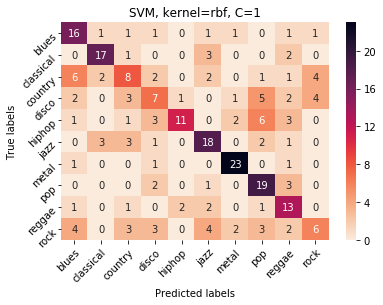

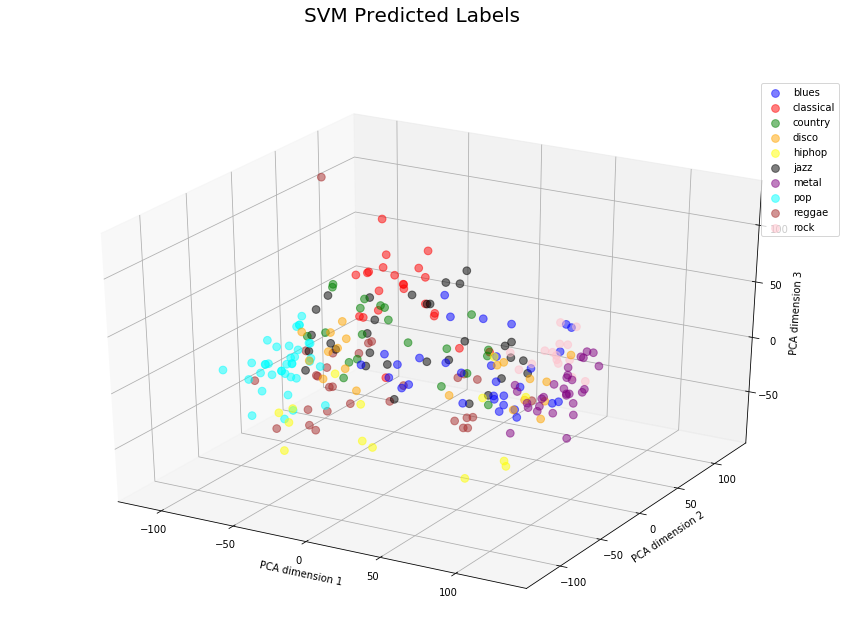

In [111]:
svm_model = SVC(kernel='rbf', gamma=1e-4, C=1)
svm_model.fit(MX_train, Y_train)
svm_predictions = svm_model.predict(MX_test)
print(classification_report(Y_test,svm_predictions))
plot_confusion_matrix(Y_test, svm_predictions, f'SVM, kernel=rbf, C=1')
plot_labels_3d(X_test, svm_predictions, 'SVM Predicted Labels')

              precision    recall  f1-score   support

         0.0       0.25      0.48      0.33        23
         1.0       0.59      0.96      0.73        23
         2.0       0.44      0.31      0.36        26
         3.0       0.44      0.28      0.34        25
         4.0       0.56      0.37      0.44        27
         5.0       0.56      0.36      0.43        28
         6.0       0.56      0.92      0.70        26
         7.0       0.53      0.84      0.65        25
         8.0       0.29      0.20      0.24        20
         9.0       0.50      0.04      0.07        27

    accuracy                           0.47       250
   macro avg       0.47      0.48      0.43       250
weighted avg       0.48      0.47      0.43       250



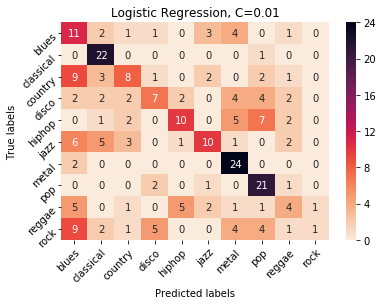

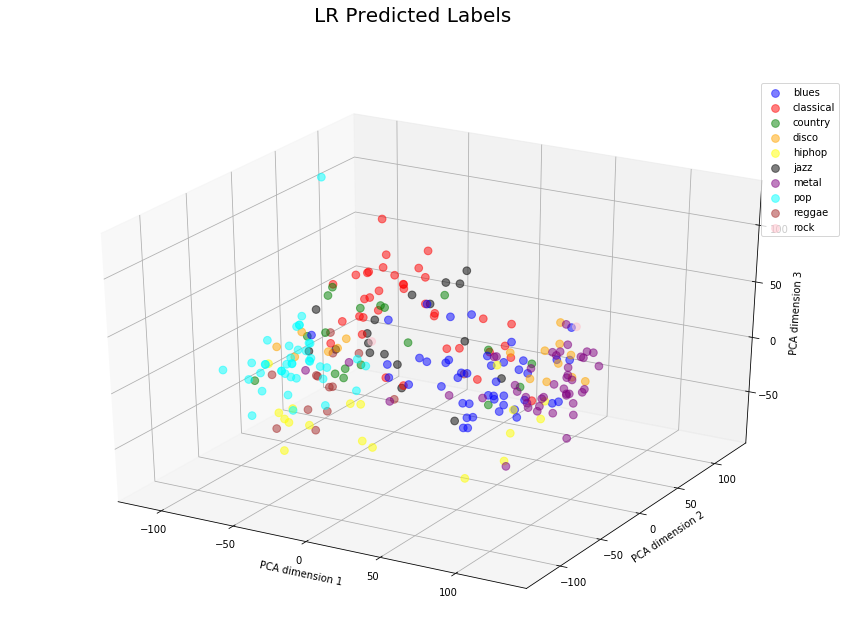

In [112]:
lr = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, C=.01)
lr.fit(MX_train, Y_train)
lr_predictions = lr.predict(MX_test)
print(classification_report(Y_test,lr_predictions))
plot_confusion_matrix(Y_test, lr_predictions, f'Logistic Regression, C={.01}')
plot_labels_3d(X_test, lr_predictions, 'LR Predicted Labels')

              precision    recall  f1-score   support

         0.0       0.30      0.26      0.28        23
         1.0       0.62      0.78      0.69        23
         2.0       0.25      0.23      0.24        26
         3.0       0.38      0.24      0.29        25
         4.0       0.38      0.22      0.28        27
         5.0       0.40      0.50      0.44        28
         6.0       0.62      0.92      0.74        26
         7.0       0.53      0.80      0.63        25
         8.0       0.44      0.35      0.39        20
         9.0       0.18      0.11      0.14        27

    accuracy                           0.44       250
   macro avg       0.41      0.44      0.41       250
weighted avg       0.40      0.44      0.41       250



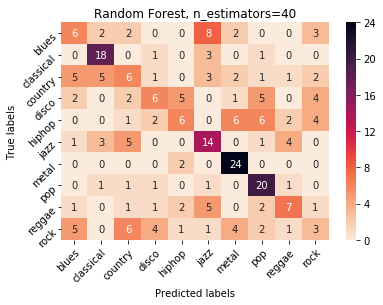

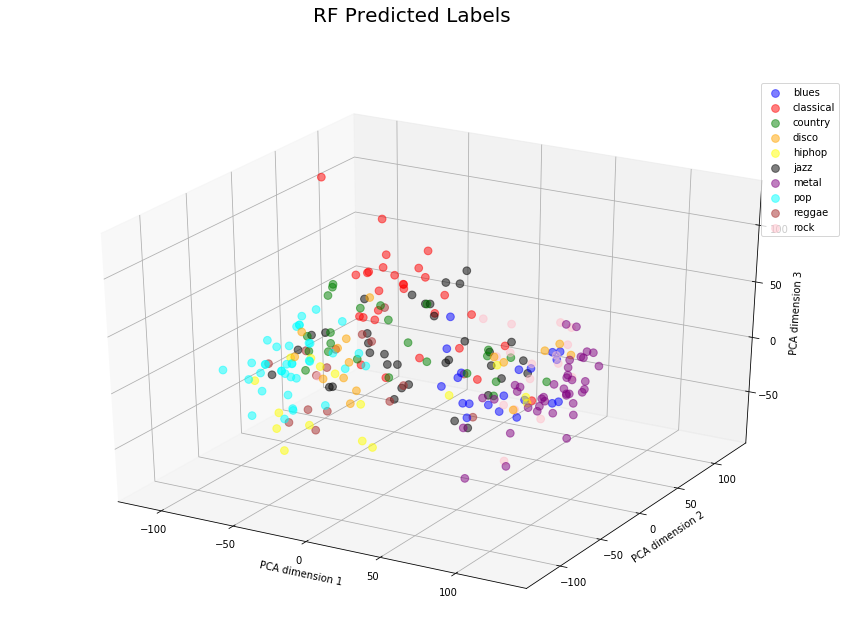

In [113]:
rf = RandomForestClassifier(n_estimators=40, max_features='sqrt')
rf.fit(MX_train, Y_train)
rf_predictions = rf.predict(MX_test)
print(classification_report(Y_test,rf_predictions))
plot_confusion_matrix(Y_test, rf_predictions, f'Random Forest, n_estimators={40}')
plot_labels_3d(X_test, rf_predictions, 'RF Predicted Labels')